# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

notebook_dir = os.getcwd()  

if notebook_dir.endswith('examples'):
    project_root = os.path.dirname(notebook_dir)
else:
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        project_root = os.path.dirname(notebook_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_wrapper import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-uf7l7kjn because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Added /Users/gabesmithline/Desktop/SRG/melo_project to Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [2]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [3]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_strategic=10,  # Number of strategic MOBI agents
    sim_time=100,  # Simulation time horizon
    lam=0.00001,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=.01,          # Mean reversion rate
    q_max=10,        # Maximum inventory
    holding_period=1, # MELO holding period
    reps=100,
    lam_melo=1
                      # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_0_100: CDA=0.00, MELO=1.00


In [5]:
# Create DPR scheduler with reduction
scheduler = DPRScheduler(
    strategies=strategies,
    num_players=10,           # Full game has 10 players (N)
    reduction_size=4,         # Reduced game has 4 players (n)
    subgame_size=min(4, len(strategies)),
    batch_size=5,
    seed=42
)

# Print information about the scaling
print(f"DPR Scaling Info: {scheduler.get_scaling_info()}")
# Expected output: DPR Scaling Info: {'full_game_players'
# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=1000,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

DPR Scaling Info: {'full_game_players': 10, 'reduced_game_players': 4, 'scaling_factor': 3.0, 'is_reduced': True}


In [6]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=100, 
    profiles_per_iteration=100,  
    save_frequency=1,   
    verbose=True         
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_0_100']

Iteration 1/100
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 100/100 [00:02<00:00, 45.75it/s]


Simulating profile 2/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 100/100 [00:01<00:00, 53.50it/s]


Simulating profile 3/5: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:02<00:00, 35.77it/s]


Simulating profile 4/5: ['MELO_0_100', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:03<00:00, 31.46it/s]


Simulating profile 5/5: ['MELO_0_100', 'MELO_0_100', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:02<00:00, 39.46it/s]

Simulation completed in 12.59 seconds

Payoff data from simulation:
  Profile: [MELO_0_100:3, MELO_100_0:1], Avg Payoff: 108.6510, Payoffs: [434.60390625, 0.0, 0.0, 0.0]
  Profile: [MELO_0_100:4], Avg Payoff: 0.0000, Payoffs: [0.0, 0.0, 0.0, 0.0]
  Profile: [MELO_100_0:4], Avg Payoff: 288402.5261, Payoffs: [285760.989375, 289724.326875, 283422.403125, 294702.385078125]
  Profile: [MELO_0_100:1, MELO_100_0:3], Avg Payoff: 173873.5284, Payoffs: [241643.157109375, 228632.30875, 225218.647578125, 0.0]
  Profile: [MELO_0_100:2, MELO_100_0:2], Avg Payoff: 81404.4990, Payoffs: [167011.916796875, 158606.0790625, 0.0, 0.0]

Finding equilibria...
Using direct 2x2 calculation. Found equilibrium: MELO_100_0:1.0000
Equilibrium regret: 0.000000

Payoff Matrix:
  MELO_0_100: [0.4178, 1.0000]
  MELO_100_0: [1.0000, 4.2268]

Found 1 equilibria in 0.00 seconds
  Equilibrium 1: regret=0.000000, MELO_100_0: 1.0000
    Expected Payoff: 635534.3832
Iteration completed in 12.59 seconds
Total profiles: 5/1000

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [7]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 1
Average regret: 0.000000
Average support size: 1.00
Support size range: 1 - 1

Top strategies:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


Top strategies by frequency:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


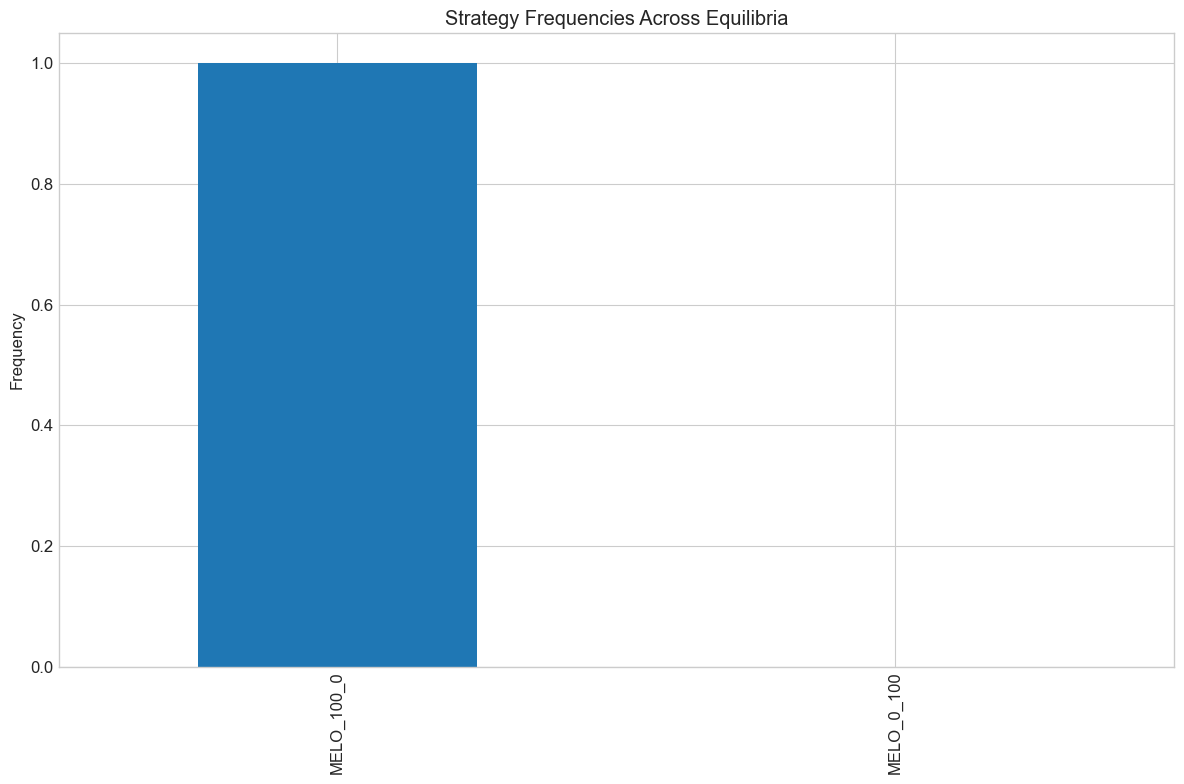

In [8]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [9]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [10]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [11]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [12]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [13]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [14]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_strategic=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    scheduler = DPRScheduler(
        strategies=strategies,
        num_players=10,           # Full game has 10 players (N)
        reduction_size=4,         # Reduced game has 4 players (n)
        subgame_size=min(3, len(strategies)),
        batch_size=5,
        seed=42
    )

    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [15]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-565.8990])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2829.4952392578125
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-565.8990])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2829.4952392578125
MELO Trade: Agent 16, Side 1, Quantity 5, Price -435.4375428728576
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2177.187714364288
MELO Trade: Agent 18, Side -1, Quantity 5, Price -435.4375428728576
Agent 18 MELO Profit before trade: 2829.4952392578125
Agent 18 MELO Profit after trade: 652.3075248935247
MELO Trade: Agent 18, Side 1, Quantity 5, Price 133.10840424543682
Agent 18 MELO Profit before trade: 652.3075248935247
Agent 18 MELO Profit after trade: -13.234496333659308
MELO Trade: Agent 16, Side -1, Quantity 5, Price 133.10840424543682
Agent 16 MELO Profit before trade: 2177.187714364288
Agent 16 MELO Profit after trade: 2842.7297355914716
MELO

100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([255.9774])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1279.8868560791016
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([255.9774])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1279.8868560791016
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-91.3069])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 456.5343475341797
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-91.3069])
Agent 17 MELO Profit before trade: -1279.8868560791016
Agent 17 MELO Profit after trade: -1736.4212036132812
MELO Trade: Agent 16, Side 1, Quantity 5, Price 868.4614026428103
Agent 16 MELO Profit before trade: 1279.8868560791016
Agent 16 MELO Profit after trade: -3062.4201571349495
MELO Trade: Agent 17, Side -1, Quantity 5, Price 868.4614026428103
Agent 17 MELO Profit before trade: -1736.4212036132812
Agent 17 MELO Profit after trade: 2605.88580960077
MELO

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 802.3627845477624
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -4011.813922738812
MELO Trade: Agent 16, Side -1, Quantity 5, Price 802.3627845477624
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 4011.813922738812
MELO Trade: Agent 17, Side 1, Quantity 5, Price 802.3627845477624
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -4011.813922738812
MELO Trade: Agent 18, Side -1, Quantity 5, Price 802.3627845477624
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4011.813922738812
MELO Trade: Agent 17, Side 1, Quantity 5, Price 454.9584059225763
Agent 17 MELO Profit before trade: -4011.813922738812
Agent 17 MELO Profit after trade: -6286.605952351693
MELO Trade: Agent 16, Side -1, Quantity 5, Price 454.9584059225763
Agent 16 MELO Profit before trade: 4011.813922738812
Agent 16 MELO Profit after trade: 6286.605952351693
MELO Trade: Agent 15, Side 1, Q

 50%|█████     | 1/2 [00:00<00:00,  5.19it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 77.52486749399058
Agent 17 MELO Profit before trade: -5299.168085223813
Agent 17 MELO Profit after trade: -5686.792422693767
MELO Trade: Agent 15, Side -1, Quantity 5, Price 77.52486749399058
Agent 15 MELO Profit before trade: -8019.300563501605
Agent 15 MELO Profit after trade: -7631.676226031652
MELO Trade: Agent 18, Side 1, Quantity 5, Price 216.25858799904935
Agent 18 MELO Profit before trade: 8020.932211013991
Agent 18 MELO Profit after trade: 6939.639271018745
MELO Trade: Agent 16, Side -1, Quantity 5, Price 216.25858799904935
Agent 16 MELO Profit before trade: 5297.536437711427
Agent 16 MELO Profit after trade: 6378.829377706674
MELO Trade: Agent 18, Side 1, Quantity 5, Price 160.9843880890823
Agent 18 MELO Profit before trade: 6939.639271018745
Agent 18 MELO Profit after trade: 6134.717330573333
MELO Trade: Agent 17, Side -1, Quantity 5, Price 160.9843880890823
Agent 17 MELO Profit before trade: -5686.792422693767
Agent 17 MELO Pr

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


MELO Trade: Agent 15, Side 1, Quantity 5, Price 79.99667227652162
Agent 15 MELO Profit before trade: 1466.2358546449843
Agent 15 MELO Profit after trade: 1066.2524932623762
MELO Trade: Agent 18, Side -1, Quantity 5, Price 79.99667227652162
Agent 18 MELO Profit before trade: -2420.768477721256
Agent 18 MELO Profit after trade: -2020.785116338648
MELO Trade: Agent 15, Side 1, Quantity 5, Price 75.95983722200997
Agent 15 MELO Profit before trade: 1066.2524932623762
Agent 15 MELO Profit after trade: 686.4533071523264
MELO Trade: Agent 16, Side -1, Quantity 5, Price 75.95983722200997
Agent 16 MELO Profit before trade: 1994.5023402500663
Agent 16 MELO Profit after trade: 2374.301526360116
MELO Trade: Agent 15, Side 1, Quantity 5, Price 78.86298738675154
Agent 15 MELO Profit before trade: 686.4533071523264
Agent 15 MELO Profit after trade: 292.13837021856864
MELO Trade: Agent 17, Side -1, Quantity 5, Price 78.86298738675154
Agent 17 MELO Profit before trade: -1039.9697171737948
Agent 17 MELO 

100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=1, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -644.4017882115892
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 3222.008941057946
MELO Trade: Agent 18, Side -1, Quantity 5, Price -644.4017882115892
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -3222.008941057946
MELO Trade: Agent 17, Side 1, Quantity 5, Price -560.082494969711
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2800.4124748485547
MELO Trade: Agent 18, Side -1, Quantity 5, Price -560.082494969711
Agent 18 MELO Profit before trade: -3222.008941057946
Agent 18 MELO Profit after trade: -6022.4214159065
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-3672.6250])
Agent 16 MELO Profit before trade: 3222.008941057946
Agent 16 MELO Profit after trade: 21585.133941057946
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-3672.6250])
Agent 18 MELO Profit before trade: -6022.4214159065
Agent 18 MELO Profit after trade: -24385.5464159065
MELO Trad

100%|██████████| 2/2 [00:00<00:00,  4.85it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price -893.9097848130493
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4469.548924065247
MELO Trade: Agent 16, Side -1, Quantity 5, Price -893.9097848130493
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -4469.548924065247
MELO Trade: Agent 18, Side 1, Quantity 5, Price 502.60520649119127
Agent 18 MELO Profit before trade: 4469.548924065247
Agent 18 MELO Profit after trade: 1956.5228916092906
MELO Trade: Agent 16, Side -1, Quantity 5, Price 502.60520649119127
Agent 16 MELO Profit before trade: -4469.548924065247
Agent 16 MELO Profit after trade: -1956.5228916092906
MELO Trade: Agent 17, Side 1, Quantity 5, Price 259.07006790849715
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1295.3503395424857
MELO Trade: Agent 16, Side -1, Quantity 5, Price 259.07006790849715
Agent 16 MELO Profit before trade: -1956.5228916092906
Agent 16 MELO Profit after trade: -661.1725520668049
MEL

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 305.0395829577116
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -1525.1979147885581
MELO Trade: Agent 18, Side -1, Quantity 5, Price 305.0395829577116
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1525.1979147885581
MELO Trade: Agent 17, Side 1, Quantity 5, Price 89.70021170440444
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -448.50105852202216
MELO Trade: Agent 15, Side -1, Quantity 5, Price 89.70021170440444
Agent 15 MELO Profit before trade: -1525.1979147885581
Agent 15 MELO Profit after trade: -1076.696856266536
MELO Trade: Agent 15, Side 1, Quantity 5, Price 262.9470469253079
Agent 15 MELO Profit before trade: -1076.696856266536
Agent 15 MELO Profit after trade: -2391.432090893076
MELO Trade: Agent 16, Side -1, Quantity 5, Price 262.9470469253079
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1314.7352346265395
MELO Trade: Agent 16, Si

 50%|█████     | 1/2 [00:00<00:00,  7.27it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 111.16823077827637
Agent 15 MELO Profit before trade: -1743.7296496261115
Agent 15 MELO Profit after trade: -2299.5708035174935
MELO Trade: Agent 16, Side -1, Quantity 5, Price 111.16823077827637
Agent 16 MELO Profit before trade: 586.7643793004906
Agent 16 MELO Profit after trade: 1142.6055331918724
MELO Trade: Agent 18, Side 1, Quantity 5, Price 145.12795759675367
Agent 18 MELO Profit before trade: 877.4954735215939
Agent 18 MELO Profit after trade: 151.85568553782548
MELO Trade: Agent 15, Side -1, Quantity 5, Price 145.12795759675367
Agent 15 MELO Profit before trade: -2299.5708035174935
Agent 15 MELO Profit after trade: -1573.931015533725
MELO Trade: Agent 15, Side 1, Quantity 5, Price 132.49082081017264
Agent 15 MELO Profit before trade: -1573.931015533725
Agent 15 MELO Profit after trade: -2236.385119584588
MELO Trade: Agent 16, Side -1, Quantity 5, Price 132.49082081017264
Agent 16 MELO Profit before trade: 1142.6055331918724
Agent

100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price 258.5480311496967
Agent 18 MELO Profit before trade: -2960.3595928389645
Agent 18 MELO Profit after trade: -4253.099748587449
MELO Trade: Agent 17, Side -1, Quantity 5, Price 258.5480311496967
Agent 17 MELO Profit before trade: 2088.582315425642
Agent 17 MELO Profit after trade: 3381.3224711741254
MELO Trade: Agent 17, Side 1, Quantity 5, Price 281.16587034346924
Agent 17 MELO Profit before trade: 3381.3224711741254
Agent 17 MELO Profit after trade: 1975.4931194567794
MELO Trade: Agent 16, Side -1, Quantity 5, Price 281.16587034346924
Agent 16 MELO Profit before trade: -3749.9992173229252
Agent 16 MELO Profit after trade: -2344.169865605579
MELO Trade: Agent 17, Side 1, Quantity 5, Price 224.3480446380026
Agent 17 MELO Profit before trade: 1975.4931194567794
Agent 17 MELO Profit after trade: 853.7528962667664
MELO Trade: Agent 15, Side -1, Quantity 5, Price 224.3480446380026
Agent 15 MELO Profit before trade: 4621.776494736248
Agent 15 ME

100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=1, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-476.0816])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2380.4080200195312
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-476.0816])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2380.4080200195312
MELO Trade: Agent 18, Side 1, Quantity 5, Price 14.034102399375328
Agent 18 MELO Profit before trade: 2380.4080200195312
Agent 18 MELO Profit after trade: 2310.2375080226548
MELO Trade: Agent 16, Side -1, Quantity 5, Price 14.034102399375328
Agent 16 MELO Profit before trade: -2380.4080200195312
Agent 16 MELO Profit after trade: -2310.2375080226548
MELO Trade: Agent 16, Side 1, Quantity 5, Price -414.66441141912
Agent 16 MELO Profit before trade: -2310.2375080226548
Agent 16 MELO Profit after trade: -236.91545092705474
MELO Trade: Agent 17, Side -1, Quantity 5, Price -414.66441141912
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2073.3220570956
MEL

 50%|█████     | 1/2 [00:00<00:00,  4.01it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 494.1372726539414
Agent 18 MELO Profit before trade: 6843.632187812243
Agent 18 MELO Profit after trade: 4372.945824542536
MELO Trade: Agent 16, Side -1, Quantity 5, Price 494.1372726539414
Agent 16 MELO Profit before trade: -9782.609331983433
Agent 16 MELO Profit after trade: -7311.922968713726
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([2534.3308])
Agent 17 MELO Profit before trade: 2938.977144171191
Agent 17 MELO Profit after trade: -9732.676908563184
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([2534.3308])
Agent 18 MELO Profit before trade: 4372.945824542536
Agent 18 MELO Profit after trade: 17044.59987727691
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([1027.6531])
Agent 16 MELO Profit before trade: -7311.922968713726
Agent 16 MELO Profit after trade: -12450.188349573102
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1027.6531])
Agent 17 MELO Profit before trade: -9732.676908563184
Agent 17

100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


MELO Trade: Agent 17, Side 1, Quantity 5, Price -259.93757206124496
Agent 17 MELO Profit before trade: 12380.500308292096
Agent 17 MELO Profit after trade: 13680.18816859832
MELO Trade: Agent 16, Side -1, Quantity 5, Price -259.93757206124496
Agent 16 MELO Profit before trade: -723.2895783110416
Agent 16 MELO Profit after trade: -2022.9774386172664
MELO Trade: Agent 17, Side 1, Quantity 5, Price -283.21709529495047
Agent 17 MELO Profit before trade: 13680.18816859832
Agent 17 MELO Profit after trade: 15096.273645073074
MELO Trade: Agent 18, Side -1, Quantity 5, Price -283.21709529495047
Agent 18 MELO Profit before trade: -11657.210729981052
Agent 18 MELO Profit after trade: -13073.296206455805
MELO Trade: Agent 18, Side 1, Quantity 5, Price 433.6247512241936
Agent 18 MELO Profit before trade: -13073.296206455805
Agent 18 MELO Profit after trade: -15241.419962576772
MELO Trade: Agent 17, Side -1, Quantity 5, Price 433.6247512241936
Agent 17 MELO Profit before trade: 15096.273645073074
A

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 17.62279214301617
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -88.11396071508085
MELO Trade: Agent 15, Side -1, Quantity 5, Price 17.62279214301617
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 88.11396071508085
MELO Trade: Agent 15, Side 1, Quantity 5, Price 201.13641656910062
Agent 15 MELO Profit before trade: 88.11396071508085
Agent 15 MELO Profit after trade: -917.5681221304224
MELO Trade: Agent 18, Side -1, Quantity 5, Price 201.13641656910062
Agent 18 MELO Profit before trade: -88.11396071508085
Agent 18 MELO Profit after trade: 917.5681221304224
MELO Trade: Agent 16, Side 1, Quantity 5, Price 87.58130664513187
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -437.90653322565936
MELO Trade: Agent 15, Side -1, Quantity 5, Price 87.58130664513187
Agent 15 MELO Profit before trade: -917.5681221304224
Agent 15 MELO Profit after trade: -479.661588904763
MELO Trade:

 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 231.75092256810177
Agent 18 MELO Profit before trade: 8792.941650430239
Agent 18 MELO Profit after trade: 7634.187037589731
MELO Trade: Agent 15, Side -1, Quantity 5, Price 231.75092256810177
Agent 15 MELO Profit before trade: -3840.2955600357604
Agent 15 MELO Profit after trade: -2681.5409471952516
MELO Trade: Agent 15, Side 1, Quantity 5, Price 256.9848337441799
Agent 15 MELO Profit before trade: -2681.5409471952516
Agent 15 MELO Profit after trade: -3966.4651159161513
MELO Trade: Agent 17, Side -1, Quantity 5, Price 256.9848337441799
Agent 17 MELO Profit before trade: -502.245698074295
Agent 17 MELO Profit after trade: 782.6784706466046
MELO Trade: Agent 15, Side 1, Quantity 5, Price 227.6336373281655
Agent 15 MELO Profit before trade: -3966.4651159161513
Agent 15 MELO Profit after trade: -5104.633302556978
MELO Trade: Agent 16, Side -1, Quantity 5, Price 227.6336373281655
Agent 16 MELO Profit before trade: -4450.4003923201835
Agent 16

100%|██████████| 2/2 [00:00<00:00,  6.72it/s]


MELO Trade: Agent 15, Side 1, Quantity 5, Price -94.08982242876245
Agent 15 MELO Profit before trade: 611.8281586964295
Agent 15 MELO Profit after trade: 1082.2772708402417
MELO Trade: Agent 17, Side -1, Quantity 5, Price -94.08982242876245
Agent 17 MELO Profit before trade: -51.17714464495555
Agent 17 MELO Profit after trade: -521.6262567887677
MELO Trade: Agent 16, Side 1, Quantity 5, Price -179.3226830349477
Agent 16 MELO Profit before trade: 3669.4238362824017
Agent 16 MELO Profit after trade: 4566.03725145714
MELO Trade: Agent 17, Side -1, Quantity 5, Price -179.3226830349477
Agent 17 MELO Profit before trade: -521.6262567887677
Agent 17 MELO Profit after trade: -1418.2396719635062
MELO Trade: Agent 18, Side 1, Quantity 5, Price -79.15261932186208
Agent 18 MELO Profit before trade: -4230.0748503338755
Agent 18 MELO Profit after trade: -3834.3117537245653
MELO Trade: Agent 16, Side -1, Quantity 5, Price -79.15261932186208
Agent 16 MELO Profit before trade: 4566.03725145714
Agent 16

100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Completed experiment. Found 1 equilibria.
Processing holding period: 5

Running experiment with holding_period=5, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


 50%|█████     | 1/2 [00:00<00:00,  8.11it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 70.99497156446282
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -354.9748578223141
MELO Trade: Agent 17, Side -1, Quantity 5, Price 70.99497156446282
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 354.9748578223141


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.27it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=5, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 197.0272746195585
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -985.1363730977926
MELO Trade: Agent 16, Side -1, Quantity 5, Price 197.0272746195585
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 985.1363730977926


100%|██████████| 2/2 [00:00<00:00,  7.91it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 222.62243151511586
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1113.1121575755792
MELO Trade: Agent 17, Side -1, Quantity 5, Price 222.62243151511586
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1113.1121575755792
Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=5, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


 50%|█████     | 1/2 [00:00<00:00,  7.13it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 192.88102449093208
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -964.4051224546604
MELO Trade: Agent 15, Side -1, Quantity 5, Price 192.88102449093208
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 964.4051224546604
MELO Trade: Agent 17, Side 1, Quantity 5, Price 331.2213264484209
Agent 17 MELO Profit before trade: -964.4051224546604
Agent 17 MELO Profit after trade: -2620.511754696765
MELO Trade: Agent 16, Side -1, Quantity 5, Price 331.2213264484209
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1656.1066322421043


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Completed experiment. Found 1 equilibria.
Processing holding period: 10

Running experiment with holding_period=10, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=10, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  7.04it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=10, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  7.34it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

Completed experiment. Found 1 equilibria.


Top strategy by holding period and arrival rate:


lam,0.05,0.10,0.20
holding_period,,,
1,MELO_100_0,MELO_100_0,MELO_100_0
5,MELO_100_0,MELO_100_0,MELO_100_0
10,MELO_100_0,MELO_100_0,MELO_100_0


<Figure size 1200x800 with 0 Axes>

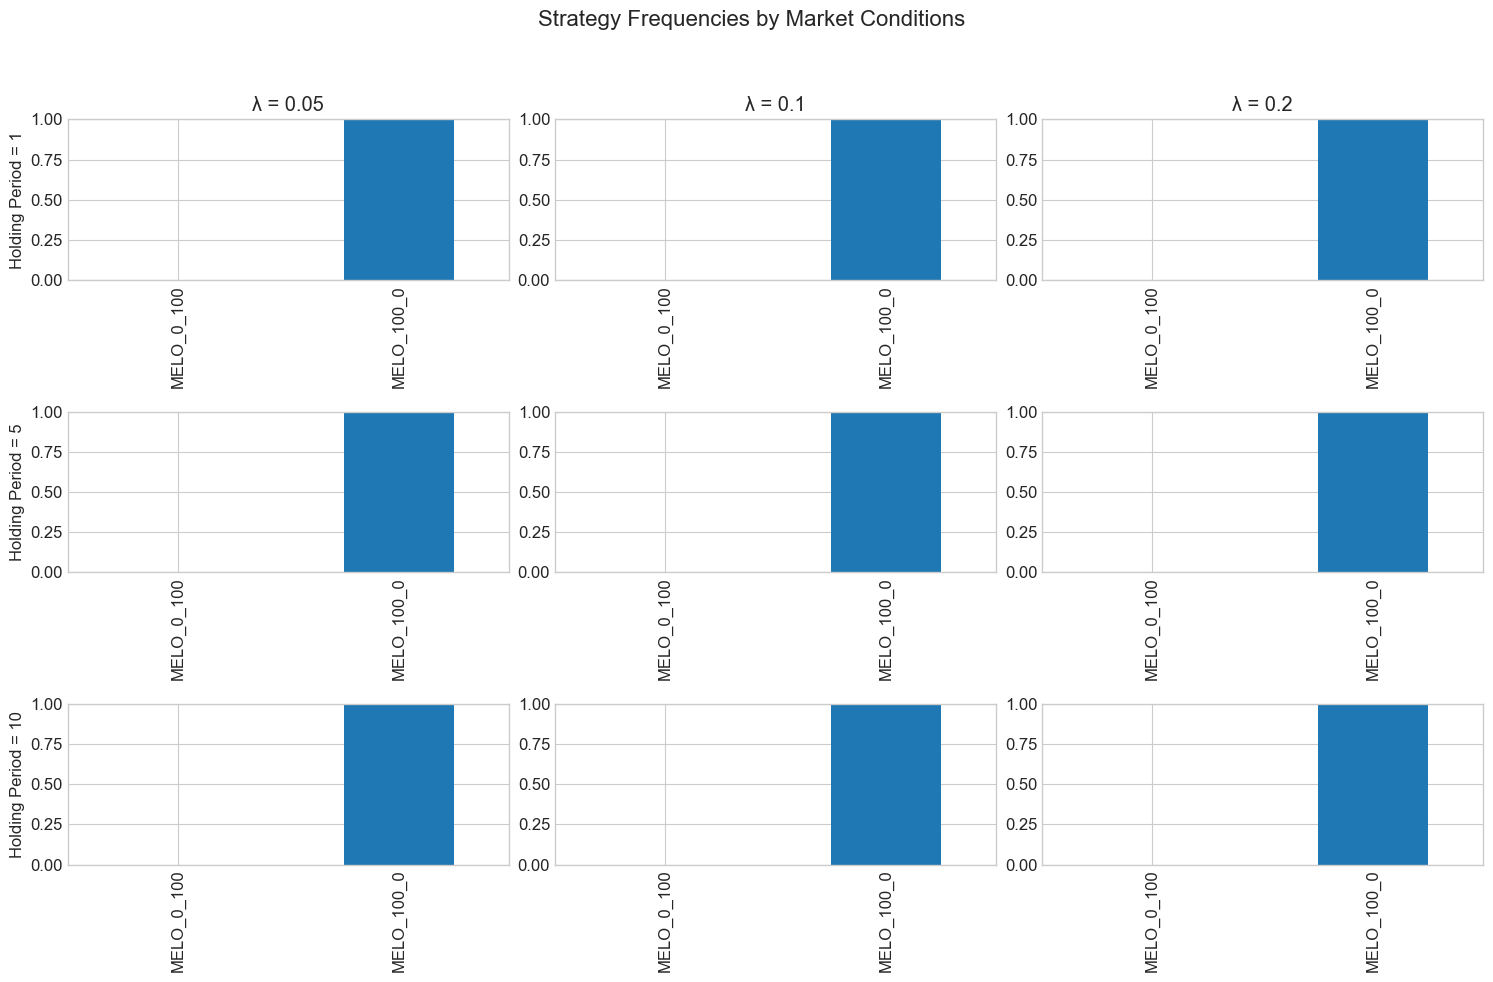

In [16]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [17]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [18]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

TypeError: MeloSimulator.__init__() got an unexpected keyword argument 'num_players'

In [19]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [ ]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

In [ ]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)

In [ ]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [23]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [ ]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

In [ ]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])